# Project: ML - Multivariate Linear Regression and Overfitting (Car Properties)

<br>

## Questions to address:
- predict fuel efficiency from car properties

<br>

## Tools:
- Models:
  - sklearn Multivariate LR (using Ordinary Least Squares)
- Error Metric: MSE, Var, $\sqrt{MSE^2+VAR^2}$ 
- Holdout and kfold Validation 

<br>

### load defaults

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import requests 

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib import rcParams
import matplotlib.dates as mdates
from datetime import datetime
from IPython.display import display, Math

from functions import *

plt.rcParams.update({'axes.titlepad': 20, 'font.size': 12, 'axes.titlesize':20})

colors = [(0/255,107/255,164/255), (255/255, 128/255, 14/255), 'red', 'green', '#9E80BA', '#8EDB8E', '#58517A']
Ncolors = 10
color_map = plt.cm.Blues_r(np.linspace(0.2, 0.5, Ncolors))
#color_map = plt.cm.tab20c_r(np.linspace(0.2, 0.5, Ncolors))


#specific to this project
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

print("Defaults Loaded")

Defaults Loaded


<br>

## Dataset: car properties that affect fuel efficiency

In [2]:
columns = ["mpg", "cylinders", "displacement", "horsepower", "weight", "acceleration", 
           "model year", "origin", "car name"]
cars = pd.read_table("./data/auto-mpg.data", delim_whitespace=True, names=columns)

#select only rows with horsepower information
filtered_cars = cars[cars['horsepower'] != '?'].copy()
filtered_cars['horsepower'] = filtered_cars['horsepower'].astype('float')

display(filtered_cars[:3])

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite


- bias: errors resulting from the learning lagorithm (for e.g. using a single variable)
  - calculate bias: trainning different models from the same class using different features and calculate errors (with linear regression, MAE, MSE or R-squared)
- variance: errors due to the variability of model's predicted values (e.g. use all variables, low bias high variance)
  - calculate variance: increase in variance as we build more complex, multi-variate models

**Overfitting**: perform well on traing set, bad on new data (every model has noise, if model overfits it captures the noise and the signal)
- detect overfitting: compare **in-sample error** and **out-of-sample error**, or **trainning** with **test** error.
- use cross validation to check out-of-sample error, if much larger than in-sample error - overfitting

train on single features

In [3]:
def train_and_test(cols):
    #Linear Regression Model
    model = LinearRegression()
    model.fit(filtered_cars[cols], filtered_cars['mpg'])  
    predictions = model.predict(filtered_cars[cols])
    
    #Variance and Error
    variance = np.var(predictions)
    mse = mean_squared_error(filtered_cars['mpg'], predictions)
    
    return(mse, variance)

(cyl_mse, cyl_var) = train_and_test(['cylinders'])
(weight_mse, weight_var) = train_and_test(['weight'])

print("MSE = {:0.3f}, Var = {:0.3f}".format(cyl_mse, cyl_var))
print("MSE = {:0.3f}, Var = {:0.3f}".format(weight_mse, weight_var))

MSE = 24.020, Var = 36.743
MSE = 18.677, Var = 42.086


train on multiple features

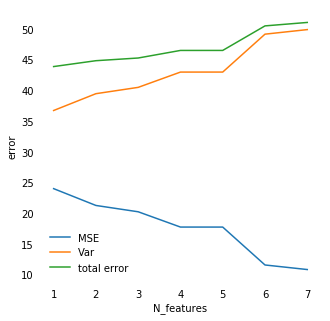

In [4]:
def train_and_test(cols):
    # Split into features & target.
    features = filtered_cars[cols]
    target = filtered_cars["mpg"]
    # Fit model.
    lr = LinearRegression()
    lr.fit(features, target)
    # Make predictions on training set.
    predictions = lr.predict(features)
    # Compute MSE and Variance.
    mse = mean_squared_error(filtered_cars["mpg"], predictions)
    variance = np.var(predictions)
    return(mse, variance)

features = ['cylinders','displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin']
#train models with one more feature at a time
mse = []
var = []
N_features = []
for ii in range(0,len(features)):
    mse_var = train_and_test(features[:ii+1])
    mse.append(mse_var[0])
    var.append(mse_var[1])
    N_features.append(len(features[:ii+1]))
    
    
fig, ax = plt.subplots(figsize=(5,5))

ax.plot(np.array(N_features), np.array(mse), label='MSE')
ax.plot(np.array(N_features), np.array(var), label='Var')
error = np.sqrt(np.array(mse)**2+np.array(var)**2)
ax.plot(np.array(N_features), np.array(error), label='total error')

ax.tick_params(left=False, right=False, top=False, bottom=False)       
for key,spine in ax.spines.items():
        spine.set_visible(False) 
ax.set_ylabel("error"), ax.set_xlabel("N_features")

ax.legend(frameon=0)
plt.show()

<br>

### kfold validation

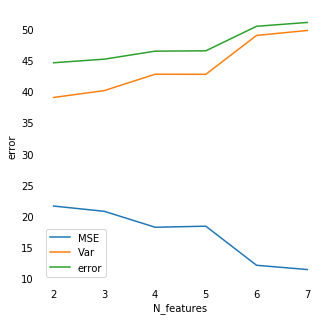

In [5]:
from sklearn.model_selection import KFold
  
  
features_list = [["cylinders", "displacement"],
                ["cylinders", "displacement", "horsepower"],
                ["cylinders", "displacement", "horsepower", "weight"],
                ["cylinders", "displacement", "horsepower", "weight", "acceleration"],
                ["cylinders", "displacement", "horsepower", "weight", "acceleration", "model year"],
                ["cylinders", "displacement", "horsepower", "weight", "acceleration","model year", "origin"]]
target = ['mpg']
k_folds = np.arange(1,10, 10)

mse_mean_list = []
var_mean_list = []
N_features = []

#run the model
for features in features_list:
    X = filtered_cars[features]
    Y = filtered_cars[target]
    mse_list = []
    var_list = []
            
    #kfold validation   
    kf = KFold(n_splits=10, shuffle=True, random_state=1)
    
    # Iterate through over each fold.
    for train_index, test_index in kf.split(X):        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
    
      
        # Fit the model and make predictions.
        lr = LinearRegression()
        lr.fit(X_train, y_train)
        predictions = lr.predict(X_test)
        
        # Calculate mse and variance values for this fold.
        mse = mean_squared_error(y_test, predictions)
        var = np.var(predictions)

        # Append to arrays to do calculate overall average mse and variance values.
        mse_list.append(mse)
        var_list.append(var)
     
    # Compute average mse and variance values.
    mse_mean_list.append(np.mean(mse_list))
    var_mean_list.append(np.mean(var_list))
    N_features.append(len(features))


fig, ax = plt.subplots(figsize=(5,5))

ax.plot(np.array(N_features), np.array(mse_mean_list), label='MSE')
ax.plot(np.array(N_features), np.array(var_mean_list), label='Var')
error = np.sqrt(np.array(mse_mean_list)**2+np.array(var_mean_list)**2)
ax.plot(np.array(N_features), np.array(error), label='error')

ax.tick_params(left=False, right=False, top=False, bottom=False)       
for key,spine in ax.spines.items():
        spine.set_visible(False) 
ax.set_ylabel("error"), ax.set_xlabel("N_features")

ax.legend()
plt.show()

- more features: lower MSE (more accurate model)
- more features: more variance (more complexity, more sensitive to small variations in input)
- best model just with one or two features